
# Train Passt-tiny on CREMA-D dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)



## Setup

In [1]:
# Notebook: Finetune PaSST for Emotion Recognition with *pluggable heads*
# =============================================================================
# Every "# %%" is a separate notebook cell.
# ▸ Choose the head by UNCOMMENTING one of the `HEAD = ...` lines in the **Config** cell.
# ▸ Adjust how many transformer blocks to unfreeze (0‑12).
# ▸ Patchout, batch size, etc. are also set in the Config cell.
# -----------------------------------------------------------------------------

# %% [markdown]
# ## 0  Config – tweak these and re‑run the notebook
# Uncomment the head you want and the number of blocks to unfreeze.
# * `linear`    = default PaSST CLS → logits head (minimal)
# * `mlp`       = 2‑layer MLP (LayerNorm‑>ReLU‑>Dropout)
# * `attentive` = attentive statistical pooling (mean & std over time tokens)
#
# VRAM tips:
#   • Smaller `BATCH` or larger `ACC_STEPS` reduces memory.
#   • Increase `patch_t`/`patch_f` to drop more patches (less VRAM, more reg.).

# %%
# ---- pick your head ---------------------------------------------------------
# HEAD = "linear"
HEAD = "mlp"         # <‑ active choice
# HEAD = "attentive"

UNFREEZE = 2          # number of last transformer blocks to fine‑tune (0‑12)
PATCH_T  = 5          # time patches dropped
PATCH_F  = 2          # freq patches dropped
BATCH    = 3         # per‑step batch size
ACC_STEPS = 2         # grad accumulation (effective batch = BATCH*ACC_STEPS)
EPOCHS   = 20
DATA_DIR = "/home/vm-user/Documents/lucky/dataset"     # folder with train/val/test csv+wav
SEED     = 42


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install PaSST transformer

In [2]:
# %% [markdown]
# ## 1  Imports
# Everything you need is here. Install missing packages with pip if necessary.

# %%
import os, random, csv
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch, torchaudio, soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

from torch import amp
from torch.amp import autocast
from tqdm.auto import tqdm

from sklearn.metrics import f1_score, confusion_matrix, classification_report

from hear21passt.base import get_model_passt
import hear21passt.models.passt as passt_module
passt_module.first_RUN = False  # silence PaSST debug prints

torch.backends.cudnn.benchmark = True


/home/vm-user/anaconda3/envs/passt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess and extract embeddings




In [3]:
# %% [markdown]
# ## 2  Utility & constants

# %%
EMOTIONS = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]
LABEL_MAP = {e: i for i, e in enumerate(EMOTIONS)}
TARGET_SR  = 32_000
NUM_SAMPLES = 1024 + (998 - 1) * 320  # 10.0 s @ 32 kHz
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", DEVICE)

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


Using cuda


## Load train/val/test Features

In [4]:
# %% [markdown]
# ## 3  Dataset → log‑mel spectrograms

# %%
class EmotionDataset(Dataset):
    def __init__(self, csv_path: Path, root: Path, augment: bool = False):
        self.records: List[Tuple[Path, int]] = []
        with open(csv_path, newline="") as f:
            for row in csv.DictReader(f):
                emo = row["emotion"].strip().upper(); fn = row["filename"].strip()
                if emo in LABEL_MAP:
                    self.records.append((root / fn, LABEL_MAP[emo]))
        if not self.records:
            raise ValueError(f"CSV {csv_path} has no usable rows!")
        self.augment = augment
        self.resample = T.Resample(TARGET_SR, TARGET_SR)
        self.mel  = T.MelSpectrogram(sample_rate=TARGET_SR, n_fft=1024, hop_length=320,
                                     n_mels=128, center=False)
        self.db   = T.AmplitudeToDB("power")
        self.pitch = lambda w: T.PitchShift(TARGET_SR, n_steps=random.uniform(-2, 2))(w)
        self.gain  = lambda w: T.Vol(gain=random.uniform(-6, 6), gain_type="db")(w)

    def __len__(self):
        return len(self.records)

    def _augment(self, w):
        if random.random() < 0.5:
            w += torch.randn_like(w) * 0.005
        if random.random() < 0.3:
            w = self.gain(w)
        if random.random() < 0.2:
            w = self.pitch(w)
        return w

    def __getitem__(self, idx):
        path, label = self.records[idx]
        try:
            w, sr = torchaudio.load(path)
        except RuntimeError:
            wav_np, sr = sf.read(path, always_2d=False)
            if wav_np.ndim == 1:
                wav_np = wav_np[None, :]
            w = torch.from_numpy(wav_np).float()
        if w.shape[0] > 1:
            w = w.mean(0, keepdim=True)
        if sr != TARGET_SR:
            w = self.resample(w)
        if self.augment:
            w = self._augment(w)
        w = (w - w.mean()) / (w.std() + 1e-9)
        mel = self.db(self.mel(w)).clamp(min=-80.0)
        mel = F.pad(mel, (0, max(0, 998 - mel.shape[2])))[:, :, :998]
        return mel, label


In [5]:
# %% [markdown]
# ## 4  Create dataloaders

# %%
root = Path(DATA_DIR)
train_ds = EmotionDataset(root / "train.csv", root / "train", augment=True)
val_ds   = EmotionDataset(root / "val.csv",   root / "val")
test_ds  = EmotionDataset(root / "test.csv",  root / "test")

collate = lambda b: (torch.stack([x for x,_ in b]), torch.tensor([y for _,y in b]))
train_loader = DataLoader(train_ds, BATCH, True,  drop_last=True, pin_memory=True, collate_fn=collate)
val_loader   = DataLoader(val_ds,   BATCH, False, pin_memory=True, collate_fn=collate)
print(len(train_ds), "train •", len(val_ds), "val •", len(test_ds), "test")


5209 train • 1116 val • 1117 test


In [6]:
# %% [markdown]
# ## 5  Build model + choose head

# %%
# --- head implementations ----------------------------------------------------
class MLPHead(nn.Module):
    def __init__(self, d_out):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LayerNorm(768), nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, d_out)
        )
    def forward(self, x):
        return self.seq(x)

class AttentivePool(nn.Module):
    def __init__(self, d):
        super().__init__(); self.att = nn.Sequential(nn.Linear(d, 128), nn.Tanh(), nn.Linear(128, 1))
    def forward(self, tok):
        w = torch.softmax(self.att(tok), dim=1)
        mu = (w * tok).sum(1)
        var = (w * (tok - mu.unsqueeze(1))**2).sum(1)
        return torch.cat([mu, var.sqrt()], 1)

def apply_head(model, head_type):
    if head_type == "linear":
        return model
    if head_type == "mlp":
        model.mlp_head = MLPHead(len(EMOTIONS)).to(DEVICE); return model
    if head_type == "attentive":
        old_ff = model.forward_features
        def new_ff(x):
            tok = old_ff(x)           # (B, T, 768)
            return AttentivePool(768).to(DEVICE)(tok)
        model.forward_features = new_ff
        model.mlp_head = nn.Linear(768*2, len(EMOTIONS)).to(DEVICE); return model
    raise ValueError(head_type)

model = get_model_passt("passt_s_swa_p16_128_ap476", pretrained=True, n_classes=len(EMOTIONS)).to(DEVICE)
model = apply_head(model, HEAD)

# unfreeze selected blocks + head
for n, p in model.named_parameters():
    train_it = n.startswith("mlp_head") or any(n.startswith(f"blocks.{i}") for i in range(12-UNFREEZE, 12))
    p.requires_grad = train_it
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "M")

# Patchout for memory & regularisation
model.train_patchout = True
model.train_patchout_t = PATCH_T
model.train_patchout_f = PATCH_F

# Criterion, optimiser, AMP scaler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=1e-2)
scaler = amp.GradScaler(device="cuda")




 Loading PASST TRAINED ON AUDISET 




/home/vm-user/anaconda3/envs/passt/lib/python3.8/site-packages/hear21passt/models/helpers/vit_helpers.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

In [7]:
## Define MLP Classifier

In [8]:
# %% [markdown]
# ## 6  Training & validation helpers

# %%

def train_one_epoch():
    model.train(); optimizer.zero_grad(); running = 0
    for i, (xb, yb) in enumerate(tqdm(train_loader, leave=False)):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with autocast(device_type="cuda"):
            logits = model(xb)
            logits = logits[0] if isinstance(logits, tuple) else logits
            loss = criterion(logits, yb) / ACC_STEPS
        scaler.scale(loss).backward()
        if (i + 1) % ACC_STEPS == 0:
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running += loss.item() * ACC_STEPS * xb.size(0)
    return running / len(train_loader.dataset)


def evaluate(loader):
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad(), autocast(device_type="cuda"):
        for xb, yb in loader:
            logits = model(xb.to(DEVICE))
            logits = logits[0] if isinstance(logits, tuple) else logits
            preds = logits.argmax(1).cpu()
            y_true.extend(yb.tolist()); y_pred.extend(preds)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return f1, y_true, y_pred

In [9]:
# %% [markdown]
# ## 7  Run training loop

# %%
best_f1 = 0
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch()
    val_f1, _, _ = evaluate(val_loader)
    print(f"Epoch {epoch:02d}: loss {train_loss:.4f} • val F1 {val_f1:.4f}")
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_passt.pt"); best_f1 = val_f1
        print("☑️  New best saved")


Epoch 01: loss 1.5053 • val F1 0.3766
☑️  New best saved


Epoch 02: loss 1.3768 • val F1 0.4176
☑️  New best saved


Epoch 03: loss 1.2981 • val F1 0.4509
☑️  New best saved


Epoch 04: loss 1.2342 • val F1 0.4687
☑️  New best saved


Epoch 05: loss 1.1731 • val F1 0.5053
☑️  New best saved


Epoch 06: loss 1.1126 • val F1 0.5058
☑️  New best saved


Epoch 07: loss 1.0609 • val F1 0.5053


Epoch 08: loss 1.0043 • val F1 0.5136
☑️  New best saved


Epoch 09: loss 0.9409 • val F1 0.5072


Epoch 10: loss 0.8632 • val F1 0.5003


Epoch 11: loss 0.8139 • val F1 0.4737


Epoch 12: loss 0.7488 • val F1 0.4850


Epoch 13: loss 0.6887 • val F1 0.5030


Epoch 14: loss 0.6385 • val F1 0.5007


Epoch 15: loss 0.5885 • val F1 0.5063


Epoch 16: loss 0.5540 • val F1 0.4707


Epoch 17: loss 0.5134 • val F1 0.5179
☑️  New best saved


Epoch 18: loss 0.4726 • val F1 0.4844


Epoch 19: loss 0.4484 • val F1 0.4978


Epoch 20: loss 0.4399 • val F1 0.4824


/tmp/ipykernel_3316873/3146340663.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_passt.pt", map_location=DEVICE))


➡️  Evaluating best checkpoint …
Test classification report:               precision    recall  f1-score   support

         ANG     0.6735    0.6911    0.6822       191
         DIS     0.4637    0.4346    0.4486       191
         FEA     0.5500    0.4053    0.4667       190
         HAP     0.4978    0.5916    0.5407       191
         NEU     0.5743    0.5215    0.5466       163
         SAD     0.5022    0.5969    0.5455       191

    accuracy                         0.5407      1117
   macro avg     0.5436    0.5401    0.5384      1117
weighted avg     0.5428    0.5407    0.5382      1117



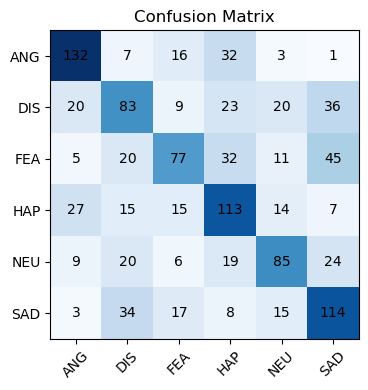

Model size (parameters + buffers): 342.21 MB
Average inference time per sample: 18.77 ms (over 200 runs)
Model size on disk (approx.): 342.21 MB
Average inference time per sample: 19.03 ms over 200 samples


In [12]:
# %% [markdown]
# ## 8  Load best model, test metrics, **model size**, and **inference time**

# %%
import time

model.load_state_dict(torch.load("best_passt.pt", map_location=DEVICE))
model.eval()

# -- test F1 & confusion matrix ------------------------------------------------
print("➡️  Evaluating best checkpoint …")


test_f1, y_true, y_pred = evaluate(DataLoader(test_ds, batch_size=BATCH, collate_fn=collate))
print("Test classification report:", classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix")
plt.xticks(range(len(EMOTIONS)), EMOTIONS, rotation=45)
plt.yticks(range(len(EMOTIONS)), EMOTIONS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# -- model size in MB ---------------------------------------------------------
param_bytes  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_bytes + buffer_bytes) / 1e6
print(f"Model size (parameters + buffers): {model_size_mb:.2f} MB")

# -- average inference time per sample ---------------------------------------
N_BENCH = 200  # number of samples to time
bench_loader = DataLoader(test_ds, batch_size=1, collate_fn=collate)
start = time.time(); n = 0
with torch.no_grad(), autocast(device_type="cuda"):
    for xb, _ in bench_loader:
        _ = model(xb.to(DEVICE))
        n += 1
        if n >= N_BENCH:
            break
end = time.time()
avg_ms = (end - start) / n * 1000
print(f"Average inference time per sample: {avg_ms:.2f} ms (over {n} runs)")

# -- end notebook ------------------------------------------------------------- in MB ----------------------------------------------------------
param_bytes  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_bytes + buffer_bytes) / 1e6
print(f"Model size on disk (approx.): {model_size_mb:.2f} MB")

# -- average inference time per sample ----------------------------------------
N_BENCH = 200  # max samples to benchmark (speeds up)
bench_loader = DataLoader(test_ds, batch_size=1, collate_fn=collate)
start = time.time(); n = 0
with torch.no_grad(), autocast(device_type="cuda"):
    for xb, _ in bench_loader:
        _ = model(xb.to(DEVICE))
        n += 1
        if n >= N_BENCH:
            break
end = time.time()
avg_ms = (end - start) / n * 1000
print(f"Average inference time per sample: {avg_ms:.2f} ms over {n} samples")


## Load train/val/test Features

In [ ]:
## Evaluation